# Setup


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# import dependencies
!pip install imutils
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from google.colab.patches import cv2_imshow
from base64 import b64decode, b64encode
import cv2
import matplotlib.pyplot as plt
import numpy as np
import PIL
import io
import html
import time
import math
import imutils
import itertools
import glob

from sklearn.cluster import KMeans

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
def imshow(image, *args, **kwargs):
    """A replacement for cv2.imshow() for use in Jupyter notebooks using matplotlib.

        Args:
          image : np.ndarray. shape (N, M) or (N, M, 1) is an NxM grayscale image. shape
            (N, M, 3) is an NxM BGR color image. 
    """
    if len(image.shape) == 3:
      # Height, width, channels
      # Assume BGR, do a conversion  
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Draw the image
    plt.imshow(image, *args, **kwargs)
    # We'll also disable drawing the axes and tick marks in the plot, since it's actually an image
    plt.axis('off')
    # Make sure it outputs
    # plt.show()
    
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

# QR Finder Patterns from Video


## QR Finder Pattern extractor


In [4]:
BLUR_VALUE = 3
SQUARE_TOLERANCE = 0.15
AREA_TOLERANCE = 0.15
DISTANCE_TOLERANCE = 0.25
WARP_DIM = 300
SMALL_DIM = 29


def count_children(hierarchy, parent, inner=False):
    if parent == -1:
        return 0
    elif not inner:
        return count_children(hierarchy, hierarchy[parent][2], True)
    return 1 + count_children(hierarchy, hierarchy[parent][0], True) + count_children(hierarchy, hierarchy[parent][2], True)


def has_square_parent(hierarchy, squares, parent):
    if hierarchy[parent][3] == -1:
        return False
    if hierarchy[parent][3] in squares:
        return True
    return has_square_parent(hierarchy, squares, hierarchy[parent][3])


def get_center(c):
    m = cv2.moments(c)
    return [int(m["m10"] / m["m00"]), int(m["m01"] / m["m00"])]


def get_angle(p1, p2):
    x_diff = p2[0] - p1[0]
    y_diff = p2[1] - p1[1]
    return math.degrees(math.atan2(y_diff, x_diff))


def get_midpoint(p1, p2):
    return [(p1[0] + p2[0]) / 2, (p1[1] + p2[1]) / 2]


def get_farthest_points(contour, center):
    distances = []
    distances_to_points = {}
    for point in contour:
        point = point[0]
        d = math.hypot(point[0] - center[0], point[1] - center[1])
        distances.append(d)
        distances_to_points[d] = point
    distances = sorted(distances)
    return [distances_to_points[distances[-1]], distances_to_points[distances[-2]]]


def line_intersection(line1, line2):
    x_diff = (line1[0][0] - line1[1][0], line2[0][0] - line2[1][0])
    y_diff = (line1[0][1] - line1[1][1], line2[0][1] - line2[1][1])

    def det(a, b):
        return a[0] * b[1] - a[1] * b[0]

    div = det(x_diff, y_diff)
    if div == 0:
        return [-1, -1]

    d = (det(*line1), det(*line2))
    x = det(d, x_diff) / div
    y = det(d, y_diff) / div
    return [int(x), int(y)]


def extend(a, b, length, int_represent=False):
    length_ab = math.sqrt((a[0] - b[0]) ** 2 + (a[1] - b[1]) ** 2)
    if length_ab * length <= 0:
        return b
    result = [b[0] + (b[0] - a[0]) / length_ab * length, b[1] + (b[1] - a[1]) / length_ab * length]
    if int_represent:
        return [int(result[0]), int(result[1])]
    else:
        return result


def extract(frame, debug=False):
    #output = frame.copy()
    output = np.zeros([frame.shape[0],frame.shape[1],4], dtype=np.uint8)

    # Remove noise and unnecessary contours from frame
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    gray = cv2.bilateralFilter(gray, 11, 17, 17)
    gray = cv2.GaussianBlur(gray, (BLUR_VALUE, BLUR_VALUE), 0)
    edged = cv2.Canny(gray, 30, 200)

    

    contours, hierarchy = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    squares = []
    square_indices = []

    i = 0
    for c in contours:
        # Approximate the contour
        peri = cv2.arcLength(c, True)
        area = cv2.contourArea(c)
        approx = cv2.approxPolyDP(c, 0.03 * peri, True)

        # Find all quadrilateral contours
        if len(approx) == 4:
            # Determine if quadrilateral is a square within SQUARE_TOLERANCE
            if area > 25 and 1 - SQUARE_TOLERANCE < math.fabs((peri / 4) ** 2) / area < 1 + SQUARE_TOLERANCE and count_children(hierarchy[0], i) >= 2 and has_square_parent(hierarchy[0], square_indices, i) is False:
                squares.append(approx)
                square_indices.append(i)
        i += 1


    main_corners = []
    east_corners = []
    south_corners = []
    tiny_squares = []
    rectangles = []

    # Determine if squares are QR codes
    for square in squares:
        area = cv2.contourArea(square)
        center = get_center(square)
        peri = cv2.arcLength(square, True)

        similar = []
        tiny = []
        for other in squares:
            if square[0][0][0] != other[0][0][0]:
                # Determine if square is similar to other square within AREA_TOLERANCE
                if math.fabs(area - cv2.contourArea(other)) / max(area, cv2.contourArea(other)) <= AREA_TOLERANCE:
                    similar.append(other)
                elif peri / 4 / 2 > cv2.arcLength(other, True) / 4:
                    tiny.append(other)

        if len(similar) >= 2:
            distances = []
            distances_to_contours = {}
            for sim in similar:
                sim_center = get_center(sim)
                d = math.hypot(sim_center[0] - center[0], sim_center[1] - center[1])
                distances.append(d)
                distances_to_contours[d] = sim
            distances = sorted(distances)
            closest_a = distances[-1]
            closest_b = distances[-2]

            # Determine if this square is the top left QR code indicator
            if max(closest_a, closest_b) < cv2.arcLength(square, True) * 2.5 and math.fabs(closest_a - closest_b) / max(closest_a, closest_b) <= DISTANCE_TOLERANCE:
                # Determine placement of other indicators (even if code is rotated)
                angle_a = get_angle(get_center(distances_to_contours[closest_a]), center)
                angle_b = get_angle(get_center(distances_to_contours[closest_b]), center)
                if angle_a < angle_b or (angle_b < -90 and angle_a > 0):
                    east = distances_to_contours[closest_a]
                    south = distances_to_contours[closest_b]
                else:
                    east = distances_to_contours[closest_b]
                    south = distances_to_contours[closest_a]
                midpoint = get_midpoint(get_center(east), get_center(south))
                # Determine location of fourth corner
                # Find closest tiny indicator if possible
                min_dist = 10000
                t = []
                tiny_found = False
                if len(tiny) > 0:
                    for tin in tiny:
                        tin_center = get_center(tin)
                        d = math.hypot(tin_center[0] - midpoint[0], tin_center[1] - midpoint[1])
                        if d < min_dist:
                            min_dist = d
                            t = tin
                    tiny_found = len(t) > 0 and min_dist < peri

                diagonal = peri / 4 * 1.41421


                # extrapolate corner based off of other corners
                farthest_a = get_farthest_points(distances_to_contours[closest_a], center)
                farthest_b = get_farthest_points(distances_to_contours[closest_b], center)
                # Use sides of indicators to determine fourth corner
                offset = line_intersection(farthest_a, farthest_b)
                if offset[0] == -1:
                    # Error, extrapolation failed, go on to next possible code
                    continue
                offset = extend(midpoint, offset, peri / 4 / 7)
                

                # Append rectangle, offsetting to farthest borders
                rectangles.append([extend(midpoint, center, diagonal / 2, True), extend(midpoint, get_center(distances_to_contours[closest_b]), diagonal / 2, True), offset, extend(midpoint, get_center(distances_to_contours[closest_a]), diagonal / 2, True)])
                east_corners.append(east)
                south_corners.append(south)
                main_corners.append(square)

    
    #debug
    #testOutput = frame.copy()
    #imshow(cv2.drawContours(testOutput, squares, -1, (255, 255, 0, 1), 2 ))



    # Draw rectangle
    for rect in rectangles:
        vrx = np.array((rect[0], rect[1], rect[2], rect[3]), np.int32)
        vrx = vrx.reshape((-1, 1, 2))
        cv2.polylines(output, [vrx], True, (0, 255, 255, 1), 2)


    # Draw debug information onto frame before outputting it
    if debug:
        cv2.drawContours(output, squares, -1, (25, 255, 5, 1), 2)
        cv2.drawContours(output, main_corners, -1, (0, 0, 128,1), 2)
        cv2.drawContours(output, east_corners, -1, (0, 128, 0,1), 2)
        cv2.drawContours(output, south_corners, -1, (128, 0, 0,1), 2)
        cv2.drawContours(output, tiny_squares, -1, (128, 128, 0,1), 2)

    return output

In [5]:
# initialize the Haar Cascade face detection model
face_cascade = cv2.CascadeClassifier(cv2.samples.findFile(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'))

## Initialize Webcam 

- start a video stream using our webcam as input
- run each frame through detection
- create an overlay image
- overlay bbx video stream

In [6]:
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

## Run

In [ ]:
# start streaming video from webcam
video_stream()
# label for video
label_html = 'Capturing...'
# initialze bounding box to empty
bbox = ''
count = 0 
while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # convert JS response to OpenCV Image
    img = js_to_image(js_reply["img"])

   
    #extract code
    frame = extract(img, True)
 
    
    frame[:,:,3] = (frame.max(axis = 2) > 0 ).astype(int) * 255

    # convert overlay of bbox into bytes
    bbox_bytes = bbox_to_bytes(frame)

    # update bbox so next frame gets new overlay
    bbox = bbox_bytes

<IPython.core.display.Javascript object>

#Hu Moments

In [ ]:
from math import copysign, log10

# Read image
im = cv2.imread('/content/drive/MyDrive/Colab Notebooks/segment.png',cv2.IMREAD_GRAYSCALE)
im2 = cv2.imread('/content/drive/MyDrive/Colab Notebooks/segment_4.png',cv2.IMREAD_GRAYSCALE)

# Threshold image
_,im = cv2.threshold(im, 128, 255, cv2.THRESH_BINARY)
_,im2 = cv2.threshold(im2, 128, 255, cv2.THRESH_BINARY)

# Calculate Moments
moment = cv2.moments(im)
moment2 = cv2.moments(im2)


# Calculate Hu Moments
huMoments = cv2.HuMoments(moment)
huMoments2 = cv2.HuMoments(moment2)

# Print Hu Moments

for i in range(0,7):
  print("Image 1: {:.5f}".format(-1*copysign(1.0,huMoments[i])*log10(abs(huMoments[i]))),end=' ')


print()
for i in range(0,7):
  print("Image 2: {:.5f}".format(-1*copysign(1.0,huMoments2[i])*log10(abs(huMoments2[i]))),end=' ')


In [ ]:
im1 = cv2.imread("/content/drive/MyDrive/Colab Notebooks/segment.png",cv2.IMREAD_GRAYSCALE)
im2 = cv2.imread("/content/drive/MyDrive/Colab Notebooks/segment_1.png",cv2.IMREAD_GRAYSCALE)
im3 = cv2.imread("/content/drive/MyDrive/Colab Notebooks/segment_2.png",cv2.IMREAD_GRAYSCALE)
im4 = cv2.imread("/content/drive/MyDrive/Colab Notebooks/segment_4.png",cv2.IMREAD_GRAYSCALE)

m1 = cv2.matchShapes(im1,im1,cv2.CONTOURS_MATCH_I2,0)
m2 = cv2.matchShapes(im1,im2,cv2.CONTOURS_MATCH_I2,0)
m3 = cv2.matchShapes(im1,im3,cv2.CONTOURS_MATCH_I2,0)
m4 = cv2.matchShapes(im1,im4,cv2.CONTOURS_MATCH_I2,0)

print("Shape Distances Between \n-------------------------")

print("1.png and 1.png : {}".format(m1))
print("1.png and 2.png : {}".format(m2))
print("1.png and 3.png : {}".format(m3))
print("1.png and 4.png : {}".format(m4))

In [ ]:
image = cv2.imread("/content/drive/MyDrive/Colab Notebooks/Closeup.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#image = cv2.GaussianBlur(image, (7, 7), 0)
#image = cv2.bilateralFilter(image, 11, 17, 17)

image = cv2.Canny(image, 1, 2)

image = cv2.dilate(image, np.ones((3)), iterations=1)
image = cv2.erode(image, np.ones((3)), iterations=1)

output = cv2.imread("/content/drive/MyDrive/Colab Notebooks/Closeup.png") #np.zeros([image.shape[0],image.shape[1],4], dtype=np.uint8)

    
contours, hierarchy = cv2.findContours(image.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

shapes=[]
for c in contours:
  peri = cv2.arcLength(c, True)
  shapes.append(cv2.approxPolyDP(c, 5, True))

output = cv2.drawContours(output, contours, -1, (255, 255, 0, 1), 2)
cv2_imshow(output)

#BLOB

-1

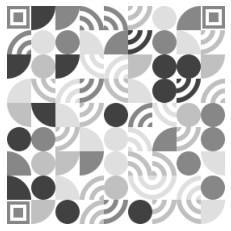

In [ ]:
im = cv2.imread("/content/drive/MyDrive/Colab Notebooks/Closeup.png", cv2.IMREAD_GRAYSCALE)

# Setup SimpleBlobDetector parameters.
params = cv2.SimpleBlobDetector_Params()

# Change thresholds
params.minThreshold = 0
params.maxThreshold = 400


# Filter by Area.
params.filterByArea = True
params.minArea = 1500



# Create a detector with the parameters
ver = (cv2.__version__).split('.')
if int(ver[0]) < 3 :
	detector = cv2.SimpleBlobDetector(params)
else : 
	detector = cv2.SimpleBlobDetector_create(params)


# Detect blobs.
keypoints = detector.detect(im)

# Draw detected blobs as red circles.
# cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS ensures
# the size of the circle corresponds to the size of blob

im_with_keypoints = cv2.drawKeypoints(im, keypoints, np.array([]), (0,0,255), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# Show blobs
imshow(im_with_keypoints)
cv2.waitKey(0)

#Template matching


##Methods

In [8]:
def dist(point1, point2):
  """ Calculates Distance between two points because math.dist() wont work"""
  temp = np.asarray(point1) - np.asarray(point2)
  return np.sqrt(np.dot(temp.T, temp))

def filterCoordinates(input_list, threshold=5):
  """ Deletes similar matches within threshold distance of points"""
  input = input_list.tolist()
  combos = itertools.combinations(input, 2)
  points_to_remove = [point2 for point1, point2 in combos if dist(point1, point2)<=threshold]
  points_to_keep = [point for point in input if point not in points_to_remove]
  return points_to_keep
  
def tupleCoord(inTuple):
  """Converts a tuple consisting of two arrays with length x into a coordinate np.array of shape (x,2)"""
  coordinates = np.zeros((inTuple[0].shape[0], 2), dtype=int)
  i = 0
  for point in zip(*inTuple[::-1]):
    coordinates[i] = (point[0],point[1])
    i +=1

  return coordinates

In [9]:
def shapeExtraction(inputImage, template, threshold=0.8):
  """Extracts the template shape from the given image.
     Returns rectangles, dimensions, overlay(rectangles drawn on transparent image)"""
  image = inputImage
  output = np.zeros([image.shape[0],image.shape[1],4], dtype=np.uint8)

  image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  image = 255 - image  

  # Store width and height of template in w and h
  w , h = template.shape[::-1]

  # Perform match operations.
  res = cv2.matchTemplate(image,template,cv2.TM_CCOEFF_NORMED)
  loc = np.where( res >= threshold)
  
  #delete similar coordinates
  rectangles = filterCoordinates(tupleCoord(loc))

  # Draw a rectangle around the matched region.
  for rectangle in rectangles:
    cv2.rectangle(output, (rectangle[0], rectangle[1]), (rectangle[0] + w, rectangle[1] + h), (255,0,0,1), 2)
  
  return rectangles, (w,h), output

In [10]:
def scaleTo(inputImage, maxSize):
  """ Scales image to a maxSize"""
  maxVal = max(inputImage.shape[0], inputImage.shape[1])
  scaleFactor = maxSize / maxVal
  width = int(inputImage.shape[1] * scaleFactor)
  height = int(inputImage.shape[0] * scaleFactor)
  dim = (width, height)

  return cv2.resize(inputImage, dim, interpolation = cv2.INTER_AREA)

In [172]:
def clusterColors(img, k):
  """Clusters Colors in a given image into k."""
  kmeans=KMeans(n_clusters=k)
  s=kmeans.fit(img)
  labels=kmeans.labels_
  centroid=kmeans.cluster_centers_
  #print(centroid)
  labels=list(labels)
  percent=[]
  for i in range(len(centroid)):
    j=labels.count(i)
    j=j/(len(labels))
    percent.append(j)
  return percent, (np.array(centroid/255))

In [57]:
import colorsys
def colorDist(color1, color2):
  r,g,b = color1[:]
  colorOne = colorsys.rgb_to_hsv(r,g,b)
  r,g,b = color2[:]
  colorTwo = colorsys.rgb_to_hsv(r,g,b)

  h0,s0,v0 = colorOne[:]
  h1,s1,v1 = colorTwo[:]
  dh = min(abs(h1-h0), 360-abs(h1-h0)) / 180.0
  ds = abs(s1-s0)
  dv = abs(v1-v0) / 255.0

  return dh#math.sqrt(dh*dh+ds*ds+dv*dv)

In [13]:
def getAngle(a, b,c):
  """Calculates the angle between three points"""
  angle = math.degrees(math.atan2(c[1]-b[1], c[0]-b[0]) - math.atan2(a[1]-b[1], a[0]-b[0]))
  return angle + 360 if angle < 0 else angle

##Id Selection

In [14]:
import glob

def saveImage(image, rotation, id, tlx, tly, brx, bry):
  #for i in range(rotation +1): image = cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)
  #for i in range(rotation +1): image = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
  #crop = image[tlx:brx,tly:bry]

  cv2.imwrite(f"cam_{tlx}:{tly},{brx}:{bry}.jpg", image)

def id_selector(image, templatePath, searchThreshold = 0.8, distanceThreshold = 0.02, angleVariance = 2, debug = False, templateKnown = ''):
  S_DIST = 0.875 #Search distance for inset point
  R_DIST = 1.1428571429 #Relative distance in width to edge based on height
  HV_TOLERANCE  = 0.0625 #Horizontal and vertical tolerance for 'parallel' points relative to distance

  if max(image.shape[:]) > 800:
    image = scaleTo(image,800)

  inputImage = image.copy()

  id_perimeter = []
  templateMatch = ''
  overlay = np.zeros([image.shape[0],image.shape[1],4], dtype=np.uint8)


  for rotation in range(0,4):
    image = cv2.rotate(image, cv2.cv2.ROTATE_90_CLOCKWISE)
    overlay = cv2.rotate(overlay, cv2.cv2.ROTATE_90_CLOCKWISE)


    for tPath in glob.glob(templatePath + "*.jpg"):     
      template = cv2.imread(tPath,0)
      if templateKnown != '':
        template= cv2.imread(templateKnown,0)

      rectangles, dimensions, _ = shapeExtraction(image,template,searchThreshold)
 
      half = int(max(dimensions[:])/2)

      midpoints = []
      for rect in rectangles:
        midpoints.append(get_midpoint(rect, (rect[0] + dimensions[0],rect[1] + dimensions[1])))
        if debug:
          cv2.circle(overlay,tuple(np.asarray(get_midpoint(rect, (rect[0] + dimensions[0],rect[1] + dimensions[1])), dtype = int)), 10, (255,255,0,1),2)

      pointMatch = []
      combos = itertools.permutations(midpoints, 3)

      for point1, point2, point3 in combos:
        d1, d2 = dist(point1, point2), dist(point2, point3)
        x1, y1 = point1[:]
        x2, y2 = point2[:]
        x3, y3 = point3[:]

        if x3 > x2 and y1 > y2 and abs(y3-y2) < (d1 * HV_TOLERANCE) and abs(x2-x1) < (d1 * HV_TOLERANCE): 
          if  (S_DIST - distanceThreshold) * d1 < d2 < (S_DIST + distanceThreshold) * d1 and \
              (270 - angleVariance < getAngle(point1,point2,point3) < 270 + angleVariance \
              or 90 - angleVariance < getAngle(point1,point2,point3) < 90 + angleVariance): 
            pointMatch.append([point1,point2,point3])
            templateMatch = tPath



      countPointSet = 0
      pointMatch = np.asarray(pointMatch).astype(int)

      for pointSet in pointMatch:
        countPointSet +=1
        tlx, tly, brx, bry = pointSet[1][0] - half, pointSet[1][1] -half, pointSet[1][0] + (dist(pointSet[1], pointSet[2])* R_DIST).astype(int) + half, pointSet[0][1] + half
        cv2.rectangle(overlay, (tlx,tly), (brx,bry),(0,255,255,1), 3 )
        id_perimeter.append([[tlx, tly],[brx,bry],[rotation]])

        saveImage(inputImage, rotation, countPointSet, tlx, tly, brx, bry)

        if debug:
          for mPoint in pointSet:
            x,y = mPoint[:]
            cv2.rectangle(overlay, (x-half, y-half)  , (x+half, y+half), (255,255,255,1), 2)

          cv2.line(overlay,  (pointSet[0][0], pointSet[0][1]), (pointSet[1][0], pointSet[1][1]), (255,0,255,1), 2)
          cv2.line(overlay,  (pointSet[1][0], pointSet[1][1]), (pointSet[2][0], pointSet[2][1]), (0,255,255,1), 2)
          cv2.line(overlay,  (pointSet[2][0], pointSet[2][1]), (pointSet[0][0], pointSet[0][1]), (255,255,0,1), 2)
          cv2.putText(overlay,"1",(pointSet[0][0], pointSet[0][1]),cv2.FONT_HERSHEY_DUPLEX, 0.5,(255, 255, 255), thickness = 2)
          cv2.putText(overlay,"2",(pointSet[1][0], pointSet[1][1]),cv2.FONT_HERSHEY_DUPLEX, 0.5,(255, 255, 255), thickness = 2)
          cv2.putText(overlay,"3",(pointSet[2][0], pointSet[2][1]),cv2.FONT_HERSHEY_DUPLEX, 0.5,(255, 255, 255), thickness = 2)
          
    #image = cv2.addWeighted(cv2.cvtColor(image, cv2.COLOR_RGB2RGBA), 1, overlay, 1,0)

  return image,overlay,id_perimeter,templateMatch





##Refactoring

In [15]:

def save(image ):
  cv2.imwrite(f"cam.jpg", image)

def getTemplateMatches(image, templatePath, searchThreshold = 0.8, templateKnown = ''):
  """Looks for template matches for each template in each rotation and returns all found matches.
     If template is already known, search effort is minimised.
     Returns templateMatches[rectangles, dimensions, rotation, templatePath]"""

  templateMatches = []

  for rotation in range(0,4):
    templates = []

    if templateKnown != '':
      templates.append([cv2.imread(templateKnown,0), templateKnown])
    else:
      for tPath in glob.glob(templatePath + "*.jpg"): templates.append([cv2.imread(tPath,0), tPath])

    for template in templates:
      rectangles, dimensions, _ = shapeExtraction(image,template[0],searchThreshold)
      if len(rectangles) >= 3:
        templateMatches.append([rectangles, dimensions, rotation, template[1]])

    image = cv2.rotate(image, cv2.cv2.ROTATE_90_CLOCKWISE)
    
    
  return templateMatches


def findFormation(templateMatches, distanceThreshold = 0.02, angleVariance = 2, debug = False):
  """"Takes array with templateMatches and searches for correct formation within one templatePattern.
      Retruns foundForations[point1,point2, rotation, tPath ]"""
  S_DIST = 0.875 #Search distance for inset point
  R_DIST = 1.1428571429 #Relative distance in width to edge based on height
  HV_TOLERANCE  = 0.0625 #Horizontal and vertical tolerance for 'parallel' points relative to distance

  foundFormation = []

  for templateMatch in templateMatches:
    rectangles, dimensions, rotation, tPath = templateMatch[:]

    half = int(max(dimensions[:])/2)

    midpoints = []
    for rect in rectangles:
      midpoints.append(get_midpoint(rect, (rect[0] + dimensions[0],rect[1] + dimensions[1])))
      

    formationMatch = []

    #Create all possible point combinations with order important
    combos = itertools.permutations(midpoints, 3)

    for point1, point2, point3 in combos:
      d1, d2 = dist(point1, point2), dist(point2, point3)
      x1, y1 = point1[:]
      x2, y2 = point2[:]
      x3, y3 = point3[:]

      if x3 > x2 and y1 > y2 and abs(y3-y2) < (d1 * HV_TOLERANCE) and abs(x2-x1) < (d1 * HV_TOLERANCE): 
        if  (S_DIST - distanceThreshold) * d1 < d2 < (S_DIST + distanceThreshold) * d1 and \
            (270 - angleVariance < getAngle(point1,point2,point3) < 270 + angleVariance \
            or 90 - angleVariance < getAngle(point1,point2,point3) < 90 + angleVariance): 
          formationMatch.append([point1,point2,point3])

    formationMatch = np.asarray(formationMatch).astype(int)

    for pointSet in formationMatch:
      tlx, tly = pointSet[1][0] - half, pointSet[1][1] -half
      brx, bry = pointSet[1][0] + (dist(pointSet[1], pointSet[2])* R_DIST).astype(int) + half, pointSet[0][1] + half

      if debug:
        foundFormation.append([(tlx, tly),(brx,bry), rotation, tPath, pointSet, half])
      else:
        foundFormation.append([(tlx, tly),(brx,bry), rotation, tPath ])
          

  return foundFormation



def debugInfo(overlay, templateMatches, formation):
  """If debug is set to true, this will show an overlay of found matches and also the correct order of points"""

  for match in templateMatches:
      rectangles,dimensions,_,_ = match[:]
      for rect in rectangles:
        cv2.circle(overlay,tuple(np.asarray(get_midpoint(rect, (rect[0] + dimensions[0],rect[1] + dimensions[1])), dtype = int)), 10, (255,255,0,1),2)
  
 
  rotation, pointSet, half = formation[2], formation[4], formation[5]
  
  for mPoint in pointSet:
    x,y = mPoint[:]
    cv2.rectangle(overlay, (x-half, y-half)  , (x+half, y+half), (255,255,255,1), 2)

  cv2.line(overlay,  (pointSet[0][0], pointSet[0][1]), (pointSet[1][0], pointSet[1][1]), (255,0,255,1), 2)
  cv2.line(overlay,  (pointSet[1][0], pointSet[1][1]), (pointSet[2][0], pointSet[2][1]), (0,255,255,1), 2)
  cv2.line(overlay,  (pointSet[2][0], pointSet[2][1]), (pointSet[0][0], pointSet[0][1]), (255,255,0,1), 2)


def getKnID(image, templatePath, searchThreshold = 0.8, distanceThreshold = 0.02, angleVariance = 2, templateKnown = '', debug = False):
  """Processes given image to find the boundaries of the KnID, in order to further process the Code.
     - templatePath       folder where the temoplates are stored
     - searchThreshold    search margin for pattern matching, more matches are found with a lower Threshhold
     - distanceThreshold  +/- distance of points to each other for formation
     - angleVariance      deviation from 90° or 270° as set angle
     - templateKnown      path to specific template if known
     - debug              overlays image with all matches found and the matched pattern formation
     Returns overlay(rgba), image with plotted area, image cropped to area of KnID"""

  if max(image.shape[:]) > 800:
    image = scaleTo(image,800)

  overlay = np.zeros([image.shape[0],image.shape[1],4], dtype=np.uint8)
  originalImage = image.copy()
  imageCrop = []


  templateMatches = getTemplateMatches(image, templatePath, searchThreshold, templateKnown)
  foundFormation = findFormation(templateMatches, distanceThreshold, angleVariance, debug)



  for formation in foundFormation:

    rotation = formation[2]
    for i in range(rotation): 
      image = cv2.rotate(image, cv2.cv2.ROTATE_90_CLOCKWISE)
      overlay = cv2.rotate(overlay, cv2.cv2.ROTATE_90_CLOCKWISE)
    
    if debug:
      debugInfo(overlay, templateMatches, formation)
      point1, point2, rotation, path, _, _ = formation[:]
    else:
      point1, point2, rotation, path = formation[:]
    
    cv2.rectangle(overlay, point2, point1,(0,255,255,1), 3 )
    imageCrop = image[point1[1]:point2[1], point1[0]:point2[0]]
    save(imageCrop)

  image_rgb = cv2.cvtColor(overlay, cv2.COLOR_RGBA2RGB)
  image = cv2.addWeighted(image, 1, image_rgb, 1, 0)

  return overlay, image, imageCrop



##From Image

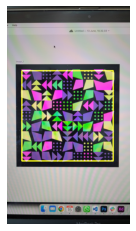

In [16]:
image = cv2.imread("/content/drive/MyDrive/Colab Notebooks/images/photo_frogpattern.jpg")
templatePath = "/content/drive/MyDrive/Colab Notebooks/images/templates/"

overlay, image, _ = getKnID(image, templatePath, 0.65)#, templateKnown = '/content/drive/MyDrive/Colab Notebooks/images/templates/template_arrow.jpg')

imshow(image)

##From Webcam

In [ ]:
templatePath = "/content/drive/MyDrive/Colab Notebooks/images/templates/"

# start streaming video from webcam
video_stream()
# label for video
label_html = 'Capturing...'
# initialze bounding box to empty
bbox = ''
count = 0 
while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # convert JS response to OpenCV Image
    img = js_to_image(js_reply["img"])

    #cv2.imwrite('image.jpg',img)
   
    #extract code
    overlay,_ = process(img, templatePath, 0.7, debug=True)

    overlay[:,:,3] = (overlay.max(axis = 2) > 0 ).astype(int) * 255

    # convert overlay of bbox into bytes
    bbox_bytes = bbox_to_bytes(overlay)

    # update bbox so next frame gets new overlay
    bbox = bbox_bytes

<IPython.core.display.Javascript object>

##Color Matching

In [ ]:
template = cv2.imread('/content/drive/MyDrive/Colab Notebooks/images/templates/template_arrow.jpg',0)
image = cv2.imread('/content/drive/MyDrive/Colab Notebooks/images/9x9_frog.jpg')


rectangles, dimensions, output = shapeExtraction(image, template,0.8)


for rect in rectangles:
  x,y = rect[:]
  w,h = dimensions[:]
  cropped = image[x:x+w,y:y+h]
  img = cropped.reshape((cropped.shape[1]*cropped.shape[0],3))
  percent, color = clusterColors(img,3)

  print(color[percent.index(max(percent))] * 255)

img = cv2.cvtColor(image, cv2.COLOR_RGB2RGBA)

imshow(cv2.addWeighted(img, 1.0, output, 1.0,0))

In [203]:
def sortRectColor(inputRectangles, dimensions, image):

  rectColors = []
  rectangles = []

  for rect in inputRectangles:
    x,y = rect[:]
    w,h = dimensions[:]
    cropped = image[y:y+h, x:x+w]
    reshaped = cropped.reshape((cropped.shape[1]*cropped.shape[0],3))
    percent, color = clusterColors(reshaped,2)
    result = np.where(color*255 >= 20)

    colorNB = []
    for coord in list(zip(result[0], result[1])):
      colorNB.append(color[coord] * 255)

    #cv2.rectangle(image, (x,y), (x+w,y+h), np.array(colorNB), 2 )

    rectColors.append(colorNB)
    rectangles.append(rect)


  #imshow(image)
  #print(rectColors)
  return rectColors, rectangles

In [217]:
rectColors, rectangles = sortRectColor(rectangles, dimensions, image)

percent, colors = clusterColors(rectColors,4)

for color in colors:
  for rectColor in rectColors:
    rectColor = np.array(rectColor)/255
    if (colorDist(color, rectColor) * 1000) < 1:
      res = np.where(colors == color)
      for coord in list(zip(res[0], res[1])):
        print(coord)


(0, 0)
(0, 1)
(0, 2)
(0, 0)
(0, 1)
(0, 2)
(1, 0)
(1, 1)
(1, 2)
(1, 0)
(1, 1)
(1, 2)
(1, 0)
(1, 1)
(1, 2)
(1, 0)
(1, 1)
(1, 2)
(1, 0)
(1, 1)
(1, 2)
(1, 0)
(1, 1)
(1, 2)
(1, 0)
(1, 1)
(1, 2)
(2, 0)
(2, 1)
(2, 2)
(2, 0)
(2, 1)
(2, 2)
(2, 0)
(2, 1)
(2, 2)
(2, 0)
(2, 1)
(2, 2)
(2, 0)
(2, 1)
(2, 2)
(2, 0)
(2, 1)
(2, 2)
(2, 0)
(2, 1)
(2, 2)
(3, 0)
(3, 1)
(3, 2)
(3, 0)
(3, 1)
(3, 2)


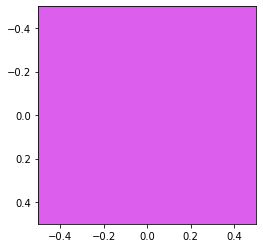

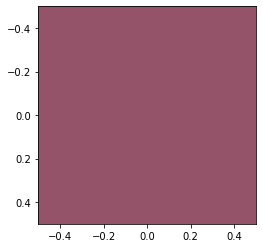

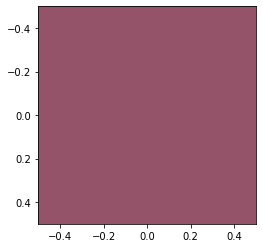

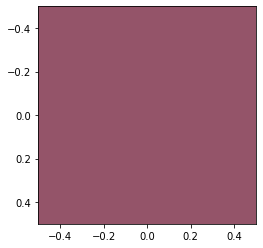

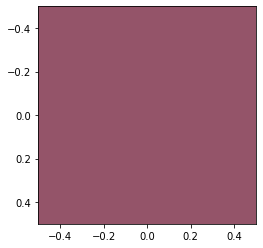

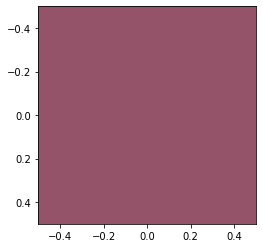

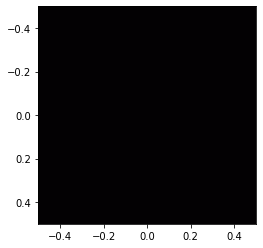

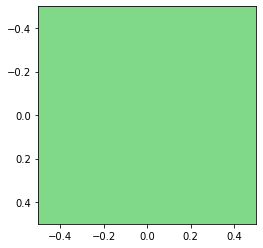

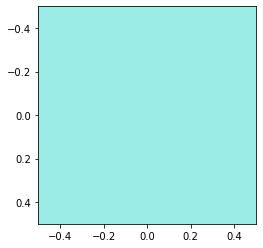

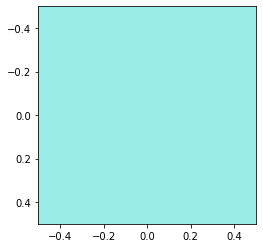

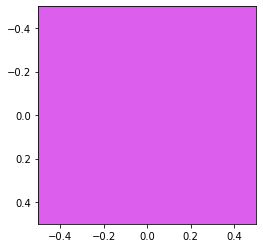

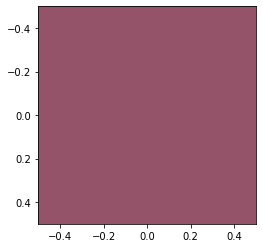

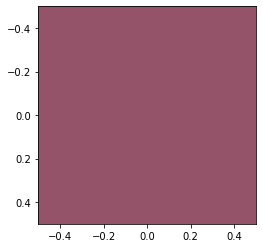

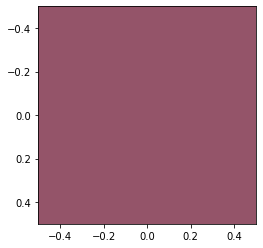

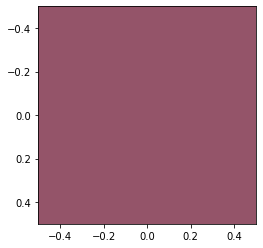

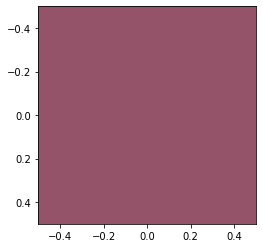

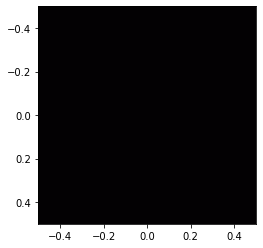

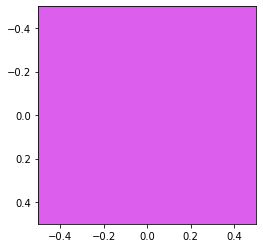

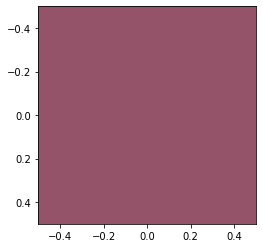

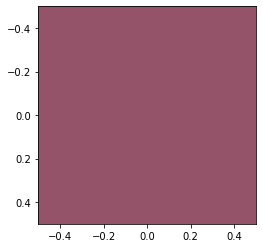

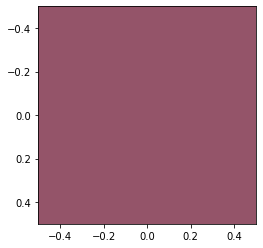

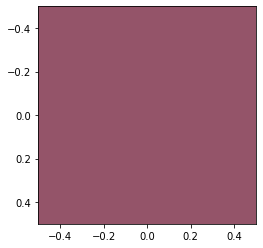

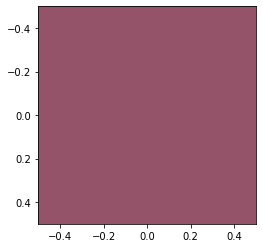

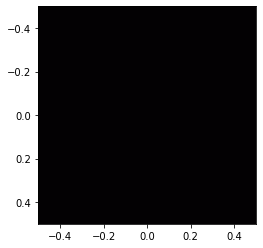

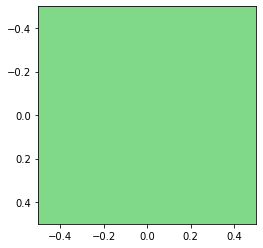

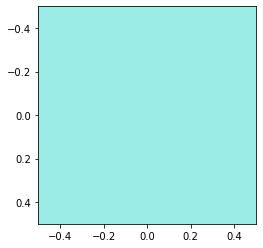

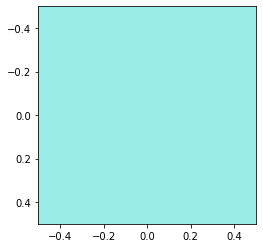

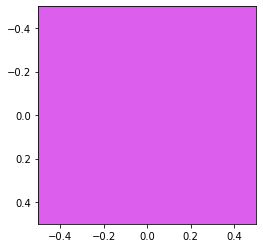

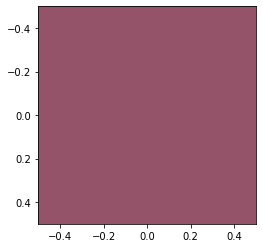

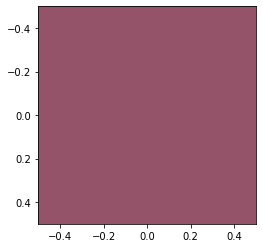

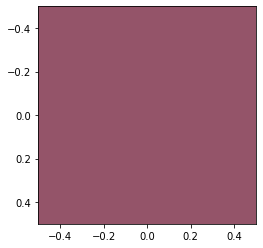

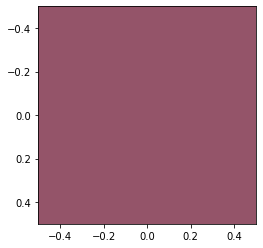

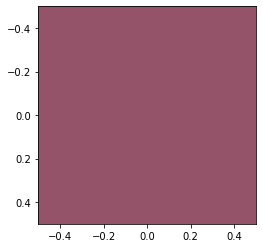

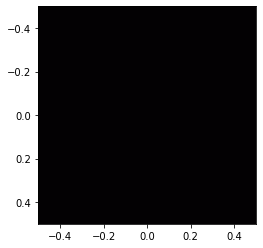

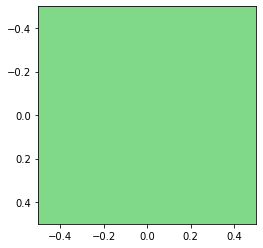

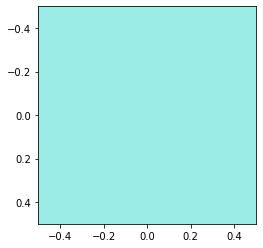

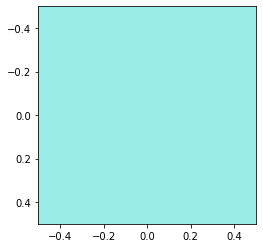

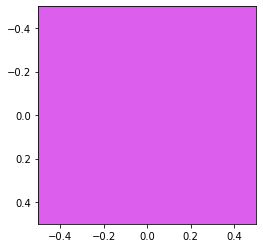

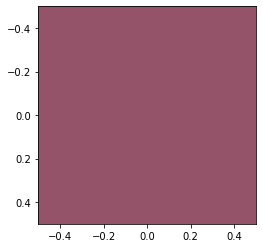

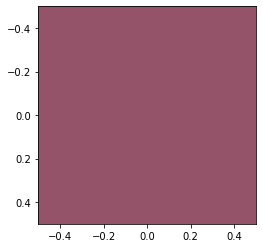

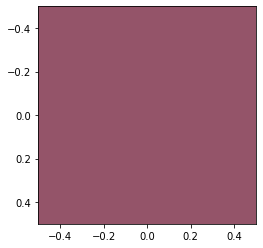

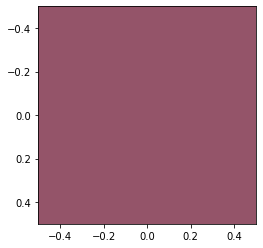

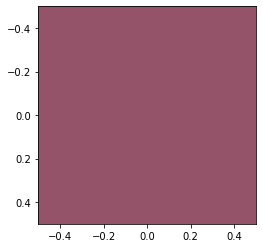

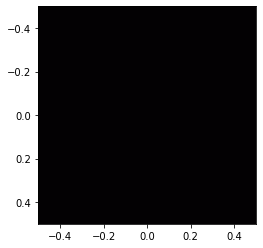

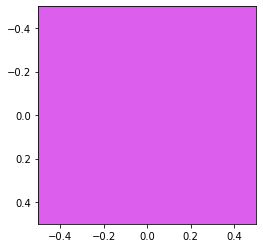

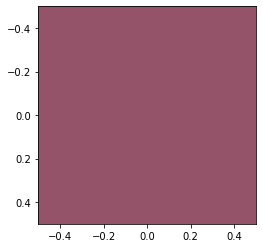

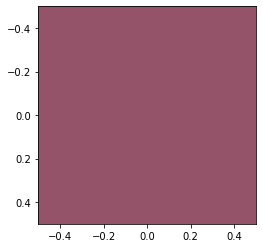

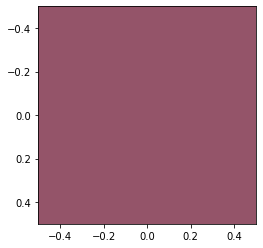

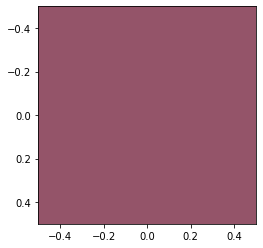

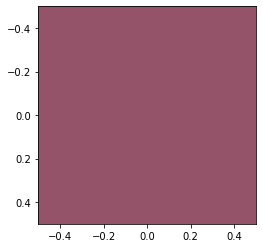

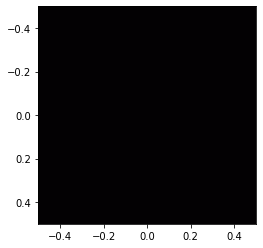

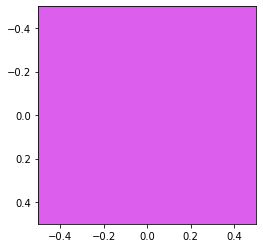

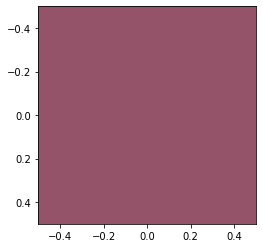

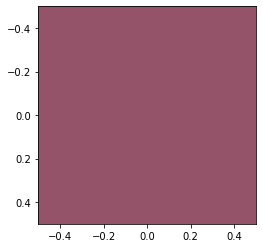

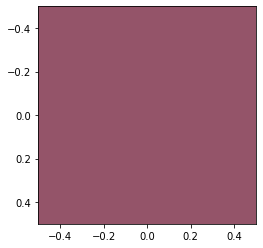

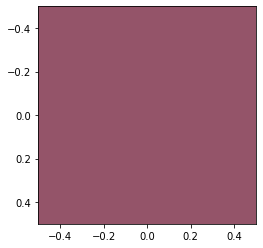

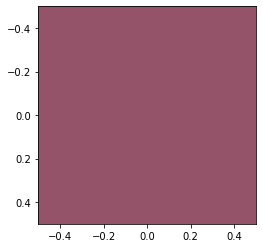

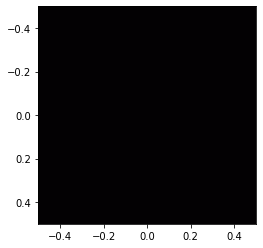

'\ni= 5\nfor color in colorMatch:\n  print(colorDist(colorMeans[i],color)*1000)\n  color = color/255\n  plt.imshow([[(color[0], color[1], color[2])]])\n  plt.show()\n  plt.imshow([[(colorMeans[i,0], colorMeans[i,1], colorMeans[i,2])]])\n  plt.show()\n'

In [129]:
import matplotlib.pyplot as plt

for meanColor in colorMeans:
  for color in colorMatch:
    if colorDist(color, meanColor)*1000 < 1:
      color = color/255
      plt.imshow([[(color[0], color[1], color[2])]])
      plt.show()

'''
i= 5
for color in colorMatch:
  print(colorDist(colorMeans[i],color)*1000)
  color = color/255
  plt.imshow([[(color[0], color[1], color[2])]])
  plt.show()
  plt.imshow([[(colorMeans[i,0], colorMeans[i,1], colorMeans[i,2])]])
  plt.show()
'''
